# Numerical Methods for the Diffusion Equation

Reference: Morton + Mayers, Numerical Solution of Partial Differential Equations (Ch. 2) , CUP (2005) 

$$% some preamble for derivatives
\newcommand{\dif}{\mathop{}\!\mathrm{d}} \newcommand\pd[3][]{\frac{\partial{#1}#2}{\partial#3{#1}}} \newcommand{\od}[3][]{\frac{\dif{#1}#2}{\dif#3{#1}}} \newcommand{\dif}{\mathrm{d}}$$
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

**Aim: To consider the forward, backward and $\theta$-method of solving the 1D diffusion equation as well as stability and convergence.**

We begin with the one-dimensional heat equation in a homogeneous unchanging medium with Dirichlet boundary conditions, i.e. find $u(x,t)$ such that

\begin{align*}
    u_t &= u _{xx} \text{    for  } t >0, \, 0<x<1,\\
    u(0,t) &= u(1,t) = 0 \text{    for } t>0,\\
    u(x,0) &= u^0(x), \text{    for } 0 \leq x \leq 1
\end{align*}

## An Analytic Solution

### Separation of variables
Assume $u(x,t) = f(x)g(t)$. Then 
\begin{align*}
    fg' &= f''g\\
    \implies g'/g &= f''/f.
\end{align*}
The left-hand side is independent of $x$ while the right hand side is independent of $t$, and so both sides must be constant which we call $-k^2$. Solving these two equations gives

$$u(x,t) = g(t)f(x) = \mathrm{e}^{-k^2t}\sin(kx)$$

If we restrict $k =m\pi, m\in \mathbb{Z}^+$, then the solution disappears at $x=0$ and $x=1$, thus satisfying the boundary condition. Furthermore, any linear combination of solutions will also solve the BC, so we can write

$$u(x,t) = \sum_{m=1}^{\infty} a_m \mathrm{e}^{-(m\pi)^2t}\sin(m\pi x).$$

The coefficients $a_m$ must be chosen to satisfy the initial condition, that is

$$\sum_{m=1}^{\infty} a_m \sin(m\pi x)  = u^0(x)$$

and so $a_m$ are the coefficents of the Fourier sine series of $u^0(x)$

$$a_m = 2 \int_0^1 u^0(x)\sin(m\pi x)  \dif x$$

Thus we have an analytic solution, albeit in terms of an infinite series and an integral. 

$$u(x,t) = \sum_{m=1}^{\infty} \bigg\lbrack 2 \mathrm{e}^{-(m\pi)^2t}\sin(m\pi x)  \int_0^1 u^0(x)\sin(m\pi x)  \dif x \bigg\rbrack $$

## An Explicit Numerical Solution

To solve the heat equation on $[0,1]$ we discretise in space and time. Let $\Delta x$ be the division in space and $\Delta t$ be the division in time. So 

\begin{align*}
 [0,1] &\rightarrow \lbrace x_j : j = 1,\dots, J\rbrace\\
 [0, t_F] &\rightarrow \lbrace  t_n : j = 1,\dots, N \rbrace\\
\end{align*}

We approximate the solution at these points, $U_j^n \approx u(x_j, t_n)$. The derivatives in time are approximated sequentially starting at $t_0$.

<img src="Images/FD_grid.svg" alt="FD_grid" width="250">

The simplest explicit scheme is to use a forward difference for the time derivative and a centred second difference for the (second-order) space derivative. 

$$\pd{u}{t}(x_j,t_n) \approx  \frac{u(x_j,t_{n+1}) - u(x_j,t_n)}{\Delta t}$$

\begin{align*}
    \pd[^2]{u}{x}(x_j,t_n) &\approx  \frac{u_x(x_{j+1},t_n) - u_x(x_j,t_n)}{\Delta x} \\
     &\approx \frac{u(x_{j+1},t_n) - 2u(x_j,t_n) + u(x_{j-1},t_n)}{(\Delta x) ^2} 
\end{align*}

Thus the discretised heat equation satisfies

\begin{equation} 
    U^{n+1}_j = U^n_j +\mu (U^n_{j+1} - 2U^n_j + U^n_{j-1}) \label{eq:FTCS}
\end{equation}

where $\mu := \Delta t / (\Delta x)^2$

![FTCS Grid](Images/FTCS_grid.svg "FTCS Grid Points")

As the right-hand side only involves solutions at the previous time step, it can be solved iteratively from the initial and boundary data! Let's apply this with the initial condition 

$$
    u^0(x) = \begin{cases} 
                    2x &\text{if } 0\leq x \leq \frac{1}{2}\\
                    2-2x &\text{if } \frac{1}{2} \leq x \leq 1
              \end{cases}
$$

In [1]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')
def FTCS(dt, N, L, J):
    t_f = N*dt

    t = np.arange(0, t_f+dt, dt)

    # Space parameters
    dx = L/J
    x = np.arange(0, L+dx , dx)

    u = np.zeros((N+1, J+1), dtype= float) #array with rows in time, columns in space

    u_0 = np.concatenate((2*x[x<=L/2], 2-2*x[x>L/2])) #Initial Conditions

    u[0,:] = u_0 

    u[:,0] = 0 #Boundary Conditions
    u[:,-1] = 0

    mu = dt/(dx**2)
    # Run the scheme as given in (1)
    for n in range(0, N): #time
        for j in range(1, J): #space
            #FTCS recursion described above
            u[n+1, j] = u[n, j] + mu * (u[n, j+1] - 2*u[n, j] + u[n, j-1])
    return x, t, u, mu

First we run the scheme with a timestep of 0.0012 and 20 mesh points in space.

In [2]:
# Set time parameters

dt = 0.0012
time_steps = 50

domain_length = 1
space_steps = 20

x, t, stable_sol, stable_mu = FTCS(dt, time_steps, domain_length, space_steps)

Plotting this over time we see a reasonable decay to equilibrium

<IPython.core.display.Javascript object>


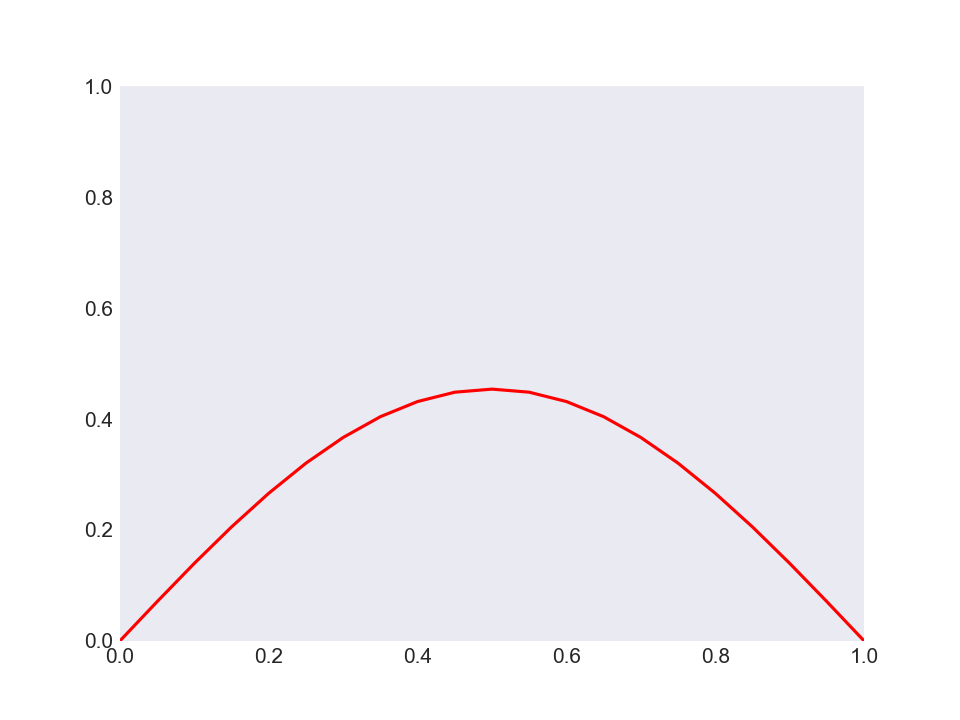

In [3]:
fig, ax= plt.subplots()

ax.set_ylim(stable_sol.min(), stable_sol.max())
ax.set_xlim(0, domain_length)

plt.ion() #Interactive mode on

line, = plt.plot(x, stable_sol[0,:], color = 'r')

fig.show()
fig.canvas.draw()

for i in range(0, time_steps):
    line.set_ydata(stable_sol[i,:]) #Updating y data is more efficient than clearing the axes every time
    time.sleep(0.25)
    fig.canvas.draw()

However, if we now adjust the time step slightly to $\Delta t = 0.0013$ we see oscillations beginning to occur and growing in time until the solution no longer represents the previous approximation at all.

<IPython.core.display.Javascript object>


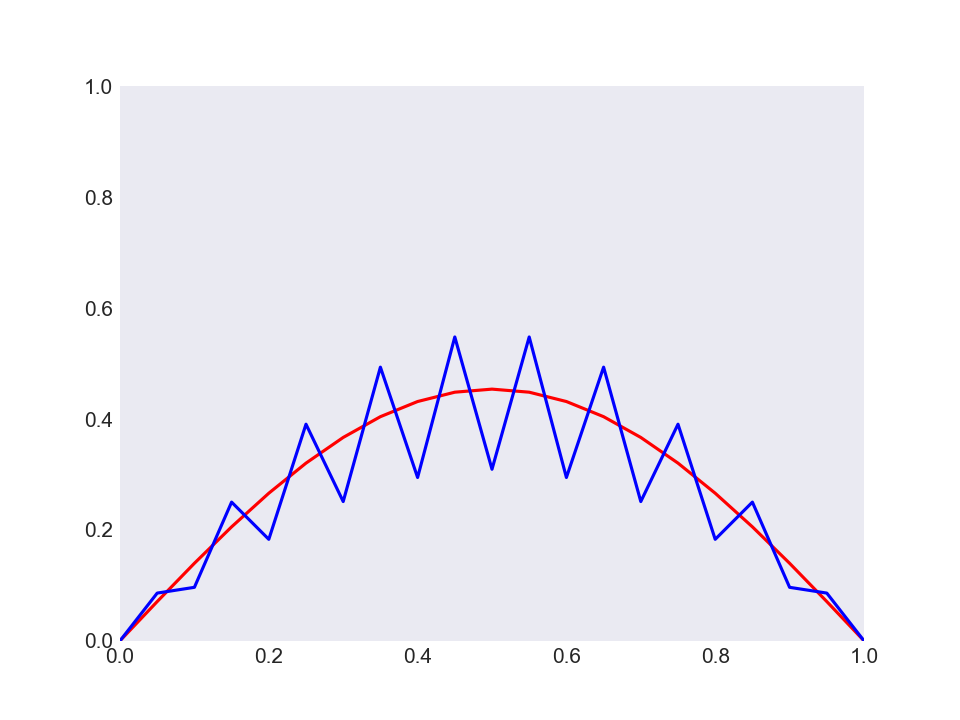

In [4]:
_dt = 0.0013
x, t, unstable_sol, unstable_mu = FTCS(_dt, time_steps, domain_length, space_steps)

fig, ax= plt.subplots()

ax.set_ylim(unstable_sol.min(), unstable_sol.max())
ax.set_xlim(0, domain_length)

plt.ion() #Interactive mode on

stab_line, = plt.plot(x, stable_sol[0,:], color = 'r')
unstab_line, = plt.plot(x, unstable_sol[0,:], color = 'b')
fig.show()
fig.canvas.draw()

for i in range(0, time_steps):
    stab_line.set_ydata(stable_sol[i,:])
    unstab_line.set_ydata(unstable_sol[i,:])
    time.sleep(0.25)
    fig.canvas.draw()

This instability is in fact due to the size of $\mu$. Add stability analysis, amplification factors.


## An Implicit Numerical Solution
To try and avoid such a restriction on the mesh size, other methods are available. One such scheme is to use a backwards difference approximation.
This leads to

\begin{equation} 
    \frac{U^{n+1}_j - U^n_j}{\Delta t} = \frac{U^{n+1}_{j+1} - 2U^{n+1}_j + U^{n+1}_{j-1}} {(\Delta x)^2} \label{eqBTCS}
\end{equation}

The stencil for this scheme is shown below.
![BTCS_grid](Images/BTCS_grid.svg)
This scheme is implicit as it involves three unknown values of $U$. This necessitates solving a system of equations simultaneously. Rewriting the system gives 

$$-\mu U^{n+1}_{j-1} + (1 + 2\mu) U^{n+1}_j - \mu U^{n+1}_{j+1} = U^n_j,$$

where $\mu = \frac{\Delta t}{(\Delta x)^2} $ as before. This is a system of $J-1$ equations in $J-1$ unknowns. Thus the simple iterative scheme from before will not be sufficient.

### The Thomas Algorithm

Add explanantion + stability

In [5]:
def BTCS(dt, N, L, J):
    dx = L/J
    mu = dt/(dx**2)
    x = np.arange(0, L+dx, dx)
    t = np.arange(0, N*dt+dt, dt)
    
    u = np.zeros((N+1, J+1), dtype= float) #array with rows in time, columns in space

    u_0 = np.concatenate((2*x[x<=L/2], 2-2*x[x>L/2])) #Initial Conditions
    u[0,:] = u_0
    
    u[:,0] = 0 #BCs 
    u[:,-1] = 0
    a = mu
    b = 1 + 2*mu 
    c = mu
    
    d = np.zeros(J)
    e = np.zeros(J)
    f = np.zeros(J)
    

    # Build arrays of new coefficients
    for n in range(1, N+1):
        for j in range(1, J):
            d[j] = u[n-1,j]
            e[j] = c/(b - a*e[j-1])
            f[j] = (d[j] + a*f[j-1]) / (b - a*e[j-1])

        for j in range(J-1, 0, -1):
            u[n,j] = f[j] + e[j]*u[n,j+1]

    return u


In [6]:
#%%timeit
dt, N, L, J = 0.0012, 50, 1, 20

BTCS_u = BTCS(dt, N, L, J)



<IPython.core.display.Javascript object>


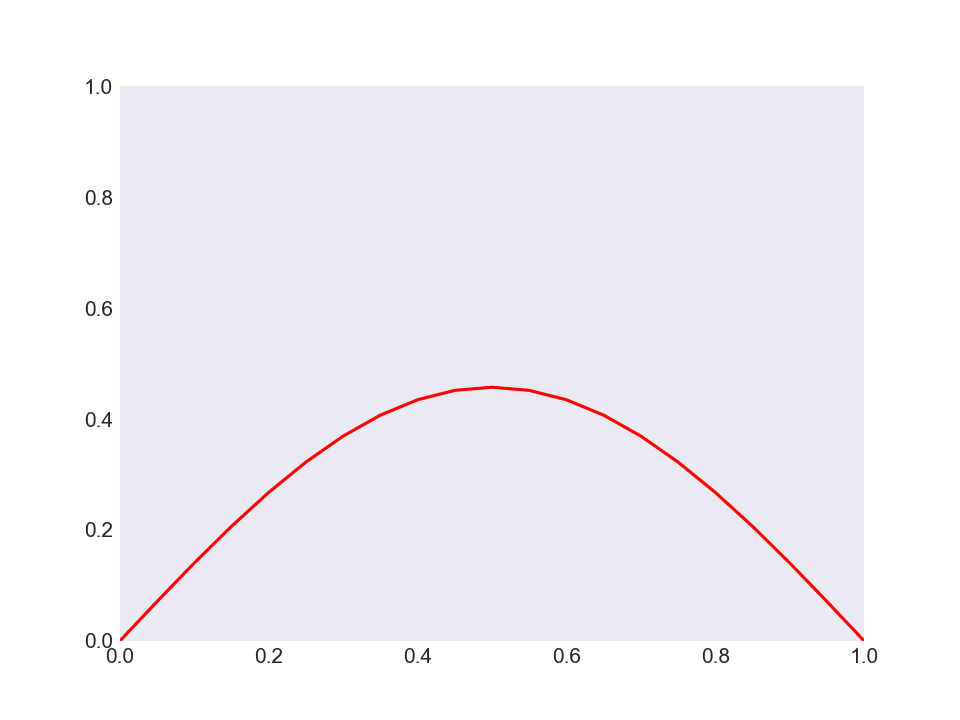

In [7]:

fig, ax= plt.subplots()

ax.set_ylim(BTCS_u.min(), BTCS_u.max())
ax.set_xlim(0, L)

plt.ion() #Interactive mode on

line, = plt.plot(x, BTCS_u[0,:], color = 'r')

fig.show()
fig.canvas.draw()

for i in range(0,N):
    line.set_ydata(BTCS_u[i,:])
    time.sleep(0.25)
    fig.canvas.draw()

## The  $\theta$-Method


![Theta_Method_Grid](Images/CN_grid.svg)


In [8]:
def theta_method(theta, dt, N, L, J):
    dx = L/J
    mu = dt/(dx**2)
    x = np.arange(0, L+dx, dx)
    t = np.arange(0, N*dt+dt, dt)
    
    u = np.zeros((N+1, J+1), dtype= float) #array with rows in time, columns in space

    u_0 = np.concatenate((2*x[x<=L/2], 2-2*x[x>L/2])) #Initial Conditions
    u[0,:] = u_0
    
    u[:,0] = 0 #BCs 
    u[:,-1] = 0
    a = theta * mu
    b = 1 + 2*theta*mu 
    c = theta*mu
    
    
    d = np.zeros(J)    
    e = np.zeros(J)
    f = np.zeros(J)
    

    # Build arrays of new coefficients
    for n in range(1, N+1):
        for j in range(1, J):
            d[j] = u[n-1,j] + (1-theta)* mu * (u[n-1,j+1] - 2*u[n-1,j] + u[n-1, j-1])
            e[j] = c/(b - a*e[j-1])
            f[j] = (d[j] + a*f[j-1]) / (b - a*e[j-1])
            
        for j in range(J-1, 0, -1):
            u[n,j] = f[j] + e[j]*u[n,j+1]

    return u


A nice experiment here is to vary the value of $\theta$ and the value of $\Delta t$ to see changes in stability for $\theta < 1/2$. For example, try $\Delta t =0.0015, \theta = 0.05$. This occurs as we are basically using the FTCS method again.

In [9]:
dt, N, L, J = 0.0015, 50, 1, 20

theta = 0.5

theta_u = theta_method(theta, dt, N, L, J)
BTCS_u = BTCS(dt, N, L, J)

<IPython.core.display.Javascript object>


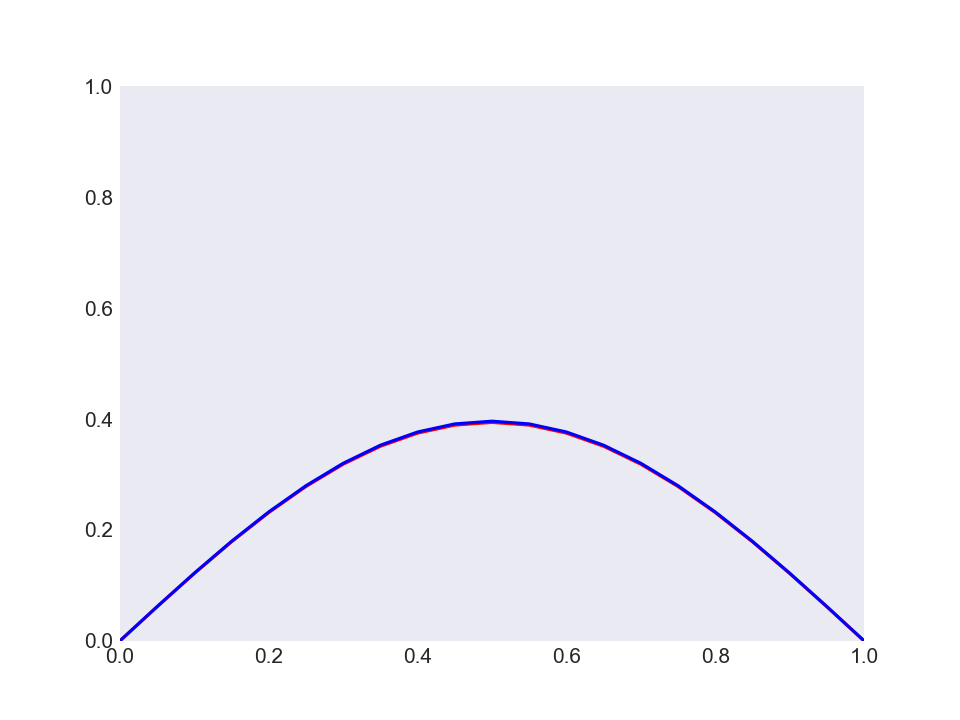

In [10]:
fig, ax= plt.subplots()

ax.set_ylim(theta_u.min(), theta_u.max())
ax.set_xlim(0, L)

plt.ion() #Interactive mode on

theta_line, = plt.plot(x, theta_u[0,:], color = 'r')
BTCS_line, = plt.plot(x, BTCS_u[0,:], color = 'b')
fig.show()
fig.canvas.draw()

for i in range(0,N):
    theta_line.set_ydata(theta_u[i,:])
    BTCS_line.set_ydata(BTCS_u[i,:])
    time.sleep(0.25)
    fig.canvas.draw()
